###### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import GammaRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

###### Loading the data and defining numerical and discrete variables 

In [2]:
df = pd.read_csv('CombinedData_ForGroup_101120.csv')

numerical_variables = ['A3.2', 'A4.2', 'B1_Age', 'B6_GPA']

discrete_variables = ['RemoteTrad', 'Subject Code', 'Class', 'Quarter', 'Year', 'Section',
       'A1_Status', 'A2_Major', 'A3.1', 'A4.1', 'A5.1', 'B2_Gender', 'B3.1_USStatus', 
       'B3.2_Country', 'B4.1_Race', 'B5_Income', 'B7_MotherEd', 'B8_FatherEd', 'B9_SocioClass',
       'B10_MajorSelection', 'B11.1', 'B11.2', 'B11.3', 'B11.4', 'B11.5', 'B11.6', 'B12.1', 'B12.2', 
       'B12.3', 'B12.4', 'B12.5', 'B12.6', 'B12.7']

###### Handling missing values, missing discrete value to nan and missing numerical value to 0

In [3]:
# missing values will be replaced by nan for discrete variables
for column in discrete_variables:
    df = df.astype({column:'str'}) 
            
for column in numerical_variables:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# missing values will be replaced by 0 for numerical variables
for row in range(df.shape[0]):
    for column in numerical_variables:
        if np.isnan(df.loc[row,column]):
            df.loc[row,column] = 0

###### Splitting the data into train, validation and test

In [4]:
y_outcome = 'PEE'
train = []
validation = []
test = []
for row in range(df.shape[0]):
    if np.isnan(df.loc[row][y_outcome]):
        df.drop(row)
    else:
        if(row % 10 == 3):
            validation.append(df.loc[row,:].values)
        elif(row % 10 == 4):
            validation.append(df.loc[row,:].values)
            test.append(df.loc[row,:].values)
        else:
            train.append(df.loc[row,:].values)
    
df_train = pd.DataFrame(train, columns = df.columns)
df_validation = pd.DataFrame(validation, columns = df.columns)
df_test = pd.DataFrame(test, columns = df.columns)
Y_train = df_train.loc[:,y_outcome].to_numpy()
Y_validation = df_validation.loc[:,y_outcome].to_numpy()
Y_test = df_test.loc[:,y_outcome].to_numpy()
print('DataFrame train :', df_train.shape)
print('DataFrame validation :', df_validation.shape)
print('DataFrame test :', df_test.shape)

DataFrame train : (842, 138)
DataFrame validation : (212, 138)
DataFrame test : (106, 138)


###### Onehot encoding for discrete features

In [5]:
# define one hot encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# transform data
onehot = pd.DataFrame(encoder.fit_transform(df_train.loc[:,discrete_variables]))
X_train_numerical = df_train.loc[:,numerical_variables]
X_train_joint = X_train_numerical.join(onehot)

# transform validation data
onehot_validation = pd.DataFrame(encoder.transform(df_validation.loc[:,discrete_variables]))
X_validation_numerical = df_validation.loc[:,numerical_variables]
X_validation_joint = X_validation_numerical.join(onehot_validation)

# transform test data
onehot_test = pd.DataFrame(encoder.transform(df_test.loc[:,discrete_variables]))
X_test_numerical = df_test.loc[:,numerical_variables]
X_test_joint = X_test_numerical.join(onehot_test)

###### Sandard scaling

In [6]:
# normalize the features by subtracting the mean and dividing by the standard deviation
scaler = preprocessing.StandardScaler().fit(X_train_joint)
X_train_scaled = scaler.transform(X_train_joint)
X_validation_scaled = scaler.transform(X_validation_joint)
X_test_scaled = scaler.transform(X_test_joint)

###### Defining Ordinary Least Squares linear regression model as baseline

In [7]:
reg = LinearRegression()

# train
reg.fit(X_train_scaled, Y_train)

# predict
Y_pred = reg.predict(X_validation_scaled)

# The mean squared error
print('MSE: %.4f'% mean_squared_error(Y_validation, Y_pred))

MSE: 0.6384


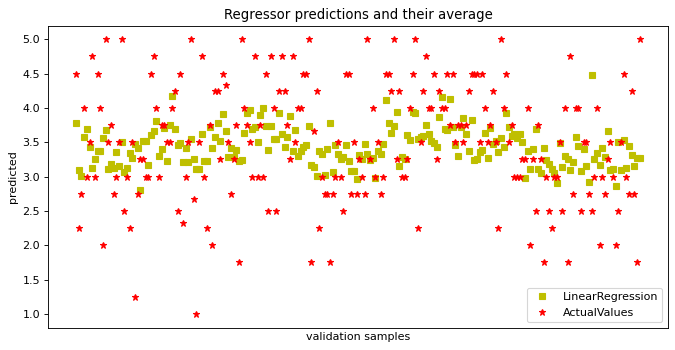

In [8]:
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

plt.plot(Y_pred, 'ys', label='LinearRegression')
plt.plot(Y_validation, 'r*', label='ActualValues')

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.ylabel('predicted')
plt.xlabel('validation samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

##### Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients.

In [9]:
ridge = GridSearchCV(Ridge(),
                       param_grid={"alpha": np.logspace(-3, 4, 8)})
# train
ridge.fit(X_train_scaled, Y_train)

# predict
Y_pred1 = ridge.predict(X_validation_scaled)

# The mean squared error
print('MSE: %.4f'% mean_squared_error(Y_validation, Y_pred1))

MSE: 0.6314


###### The Lasso is a linear model that estimates sparse coefficients.

In [10]:
lasso = GridSearchCV(Lasso(),
                       param_grid={"alpha": np.logspace(0, 4, 5)})
# train
lasso.fit(X_train_scaled, Y_train)

# predict
Y_pred2 = lasso.predict(X_validation_scaled)

# The mean squared error
print('MSE: %.4f'% mean_squared_error(Y_validation, Y_pred2))

MSE: 0.7339


###### ElasticNet is a linear regression model trained with both L1 and L2 norm regularization of the coefficients.

In [11]:
elastic = GridSearchCV(ElasticNet(),
                       param_grid={"alpha": np.logspace(-2, 3, 6)})
# train
elastic.fit(X_train_scaled, Y_train)

# predict
Y_pred3 = elastic.predict(X_validation_scaled)

# The mean squared error
print('MSE: %.4f'% mean_squared_error(Y_validation, Y_pred3))

MSE: 0.7339


###### Generalized Linear Regression, assuming Poisson distribution

In [12]:
poisson = GridSearchCV(PoissonRegressor(),
                       param_grid={"alpha": np.logspace(-2, 3, 6)})
# train
poisson.fit(X_train_scaled, Y_train)

# predict
Y_pred4 = poisson.predict(X_validation_scaled)

# The mean squared error
print('MSE: %.4f'% mean_squared_error(Y_validation, Y_pred4))

MSE: 0.6303


###### Generalized Linear Regression, assuming Gamma distribution

In [13]:
gamma = GridSearchCV(GammaRegressor(),
                       param_grid={"alpha": np.logspace(-2, 3, 6)})
# train
gamma.fit(X_train_scaled, Y_train)

# predict
Y_pred5 = gamma.predict(X_validation_scaled)

# The mean squared error
print('MSE: %.4f'% mean_squared_error(Y_validation, Y_pred5))

MSE: 0.6402


###### Epsilon-Support Vector Regression

In [14]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "epsilon": np.logspace(-2, 2, 5)})
# train
svr.fit(X_train_scaled, Y_train)

# predict
Y_pred6 = svr.predict(X_validation_scaled)

# The mean squared error
print('MSE: %.4f'% mean_squared_error(Y_validation, Y_pred6))

MSE: 0.7427


###### Nu Support Vector Regression

In [15]:
nusvr = GridSearchCV(NuSVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "nu": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]})
# train
nusvr.fit(X_train_scaled, Y_train)

# predict
Y_pred7 = nusvr.predict(X_validation_scaled)

# The mean squared error
print('MSE: %.4f'% mean_squared_error(Y_validation, Y_pred7))

MSE: 0.7380


###### Stochastic Gradient Descent

In [16]:
sgd = GridSearchCV(SGDRegressor(max_iter=1000, tol=1e-3),
                   param_grid={"alpha": np.logspace(-5, 2, 8)})
# train
sgd.fit(X_train_scaled, Y_train)

# predict
Y_pred8 = sgd.predict(X_validation_scaled)

# The mean squared error
print('MSE: %.4f'% mean_squared_error(Y_validation, Y_pred8))

MSE: 0.6911


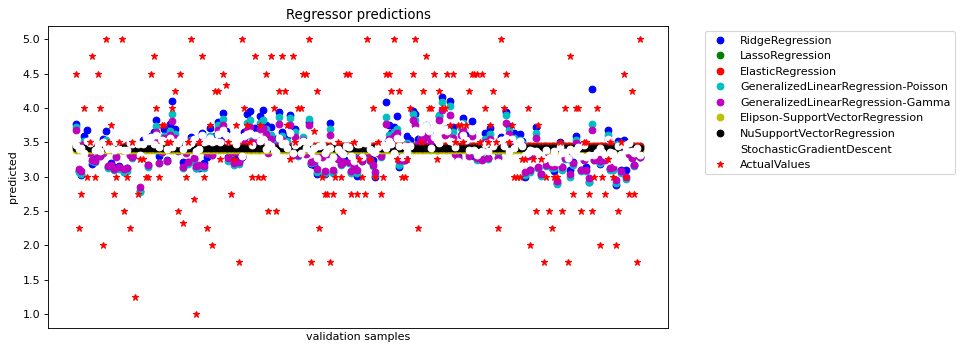

In [17]:
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

plt.plot(Y_pred1, 'bo', label='RidgeRegression')
plt.plot(Y_pred2, 'go', label='LassoRegression')
plt.plot(Y_pred3, 'ro', label='ElasticRegression')
plt.plot(Y_pred4, 'co', label='GeneralizedLinearRegression-Poisson')
plt.plot(Y_pred5, 'mo', label='GeneralizedLinearRegression-Gamma')
plt.plot(Y_pred6, 'yo', label='Elipson-SupportVectorRegression')
plt.plot(Y_pred7, 'ko', label='NuSupportVectorRegression')
plt.plot(Y_pred8, 'wo', label='StochasticGradientDescent')
plt.plot(Y_validation, 'r*', label='ActualValues')

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.ylabel('predicted')
plt.xlabel('validation samples')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Regressor predictions')

plt.show()

###### Use test data for the best model found

In [18]:
Y_pred_test = poisson.predict(X_test_scaled)
# The mean squared error
print('MSE: %.4f'% mean_squared_error(Y_test, Y_pred_test))

MSE: 0.7110
